In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
data = pd.read_csv('time-series-19-covid-combined.csv', parse_dates=True)

In [3]:
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0


In [4]:
date_df = data.groupby('Date')[['Confirmed' ,'Recovered', 'Deaths']].sum()

In [5]:
date_df.head()

,Confirmed,Recovered,Deaths
Date,,,
2020-01-22,555.0,28.0,17.0
2020-01-23,654.0,30.0,18.0
2020-01-24,941.0,36.0,26.0
2020-01-25,1434.0,39.0,42.0
2020-01-26,2118.0,52.0,56.0


In [6]:
date_df['currentCase'] = date_df['Confirmed'] - date_df['Recovered'] - date_df['Deaths']

In [7]:
date_df.describe()

,Confirmed,Recovered,Deaths,currentCase
count,1.210000e+02,1.210000e+02,121.000000,1.210000e+02
mean,1.336900e+06,4.157160e+05,88925.917355,8.322581e+05
std,1.609010e+06,5.551710e+05,112030.682478,9.536467e+05
min,5.550000e+02,2.800000e+01,17.000000,5.100000e+02
25%,7.681900e+04,1.889000e+04,2251.000000,4.452900e+04
50%,3.370220e+05,9.789900e+04,14826.000000,2.242970e+05
75%,2.549046e+06,6.799050e+05,180236.000000,1.688905e+06
max,5.102424e+06,1.948739e+06,332924.000000,2.820761e+06


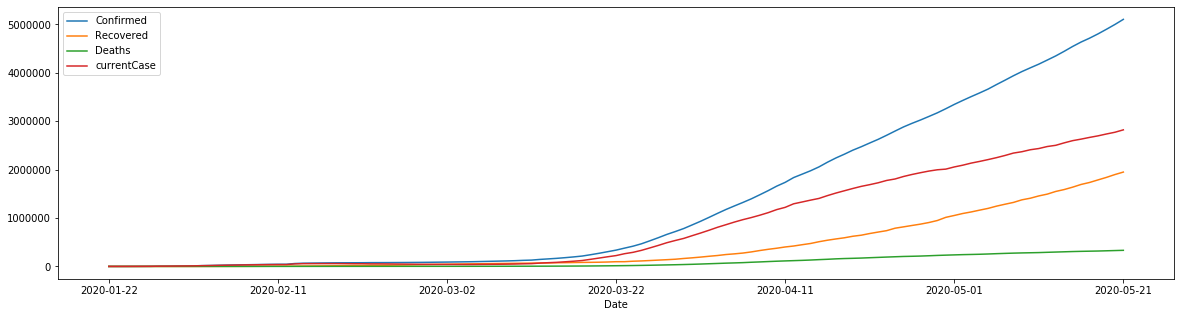

In [8]:
date_df.plot(kind='line', figsize=(20,5))

In [9]:
# Time series forecasting
import fbprophet

In [10]:
dir(fbprophet)

['Prophet',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'diagnostics',
 'forecaster',
 'hdays',
 'make_holidays',
 'models',
 'plot']

In [11]:
# Model initialization
from fbprophet import Prophet
model = Prophet()

In [12]:
# Add seasonality
model.add_seasonality(name='Monthly', period=30.42, fourier_order=5)

In [13]:
### Splitting datasets operation
global_cases = date_df.reset_index()
confirmed_df = global_cases[['Date', 'Confirmed']]
recovered_df = global_cases[['Date', 'Recovered']]
deaths_df = global_cases[['Date', 'Deaths']]

In [14]:
# For Prophet to predict, its required for the names on the variables to be ds and y
def rename_func(dataframe):
    cols = dataframe.columns
    dataframe.rename(columns= {cols[0]: 'ds', cols[1]:'y'}, inplace= True)
    return dataframe

In [15]:
confirmed_df = rename_func(confirmed_df)
recovered_df = rename_func(recovered_df)
deaths_df = rename_func(deaths_df)

/home/qwerty/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
confirmed_df.head()

,ds,y
0,2020-01-22,555.0
1,2020-01-23,654.0
2,2020-01-24,941.0
3,2020-01-25,1434.0
4,2020-01-26,2118.0


In [17]:
def train_test_split(dataframe, ratio):
    """
    Parameters:
    dataframe- Dataframe required to be split
    ratio: Percentage of training split in the scale of 0-100
    """
    divisor = round((ratio/100)*dataframe.shape[0])
    print(divisor)
    train = dataframe.iloc[:divisor]
    test = dataframe.iloc[divisor:]
    return train, test

In [18]:
confirmed_train, confirmed_test = train_test_split(confirmed_df, 70)

85


In [19]:
confirmed_train.shape, confirmed_test.shape

((85, 2), (36, 2))

In [20]:
confirmed_test.head()

,ds,y
85,2020-04-16,2152181.0
86,2020-04-17,2239990.0
87,2020-04-18,2317636.0
88,2020-04-19,2400787.0
89,2020-04-20,2472109.0


In [22]:
# Fitting model
model.fit(confirmed_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
# Creating future dates
future_dates = model.make_future_dataframe(periods=36)

In [24]:
# Making predictions
predictions = model.predict(future_dates)

In [26]:
x= predictions.iloc[85:]
x.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Monthly,Monthly_lower,Monthly_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
85,2020-04-16,2.111547e+06,2.131908e+06,2.138920e+06,2.111044e+06,2.111759e+06,24433.120850,24433.120850,24433.120850,23977.740738,23977.740738,23977.740738,-455.380112,-455.380112,-455.380112,0.0,0.0,0.0,2.135525e+06
86,2020-04-17,2.188365e+06,2.209144e+06,2.218509e+06,2.184722e+06,2.191507e+06,23702.735256,23702.735256,23702.735256,25666.094429,25666.094429,25666.094429,1963.359173,1963.359173,1963.359173,0.0,0.0,0.0,2.214031e+06
87,2020-04-18,2.265182e+06,2.281309e+06,2.297521e+06,2.256201e+06,2.272202e+06,22349.948515,22349.948515,22349.948515,24626.619969,24626.619969,24626.619969,2276.671454,2276.671454,2276.671454,0.0,0.0,0.0,2.289809e+06
88,2020-04-19,2.342000e+06,2.348542e+06,2.376392e+06,2.327530e+06,2.354300e+06,20070.419799,20070.419799,20070.419799,21947.067817,21947.067817,21947.067817,1876.648018,1876.648018,1876.648018,0.0,0.0,0.0,2.363947e+06
89,2020-04-20,2.418818e+06,2.413338e+06,2.452495e+06,2.397369e+06,2.437125e+06,16629.736289,16629.736289,16629.736289,15776.215750,15776.215750,15776.215750,-853.520539,-853.520539,-853.520539,0.0,0.0,0.0,2.434594e+06


In [35]:
confirmed_test.head()

,ds,y
85,2020-04-16,2152181.0
86,2020-04-17,2239990.0
87,2020-04-18,2317636.0
88,2020-04-19,2400787.0
89,2020-04-20,2472109.0


In [27]:
x.shape, confirmed_test.shape

((36, 19), (36, 2))

In [31]:
score = np.sqrt(mean_squared_error(confirmed_test.y ,x.yhat))
print('RMSE for Polynomial Regression => {}\n'.format( score))

RMSE for Polynomial Regression => 134762.2900711042



In [32]:
from sklearn.metrics import r2_score
r2_score(confirmed_test.y ,x.yhat)

0.9757011175332593

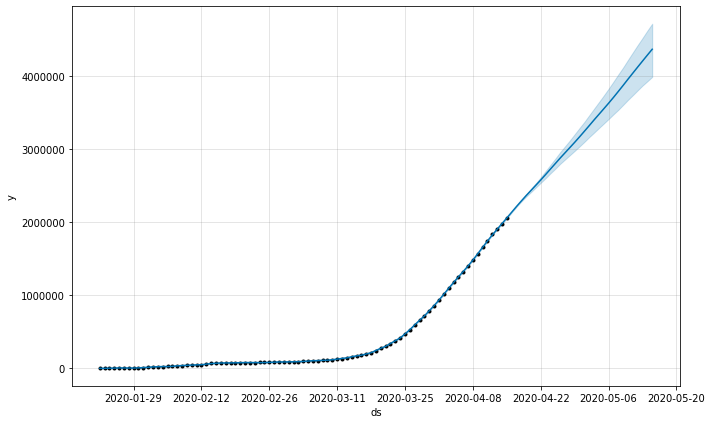

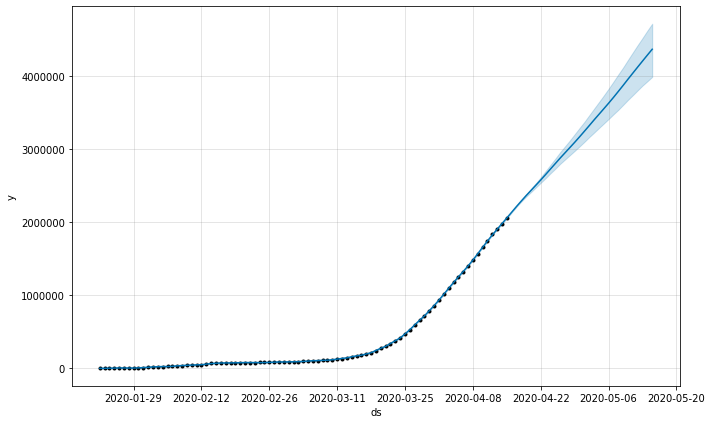

In [29]:
model.plot(predictions)

In [28]:
score = np.sqrt(mean_squared_error(confirmed_test['y'] ,predictions['yhat'].iloc[:36]))
print('RMSE for Polynomial Regression => {}\n'.format( score))

RMSE for Polynomial Regression => 3633386.6544569884



In [54]:
from sklearn.metrics import r2_score
r2_score(confirmed_test['y'] ,predictions['yhat'].iloc[79:])

0.5441435798821976

In [56]:
mean_squared_error(confirmed_test.y, predictions.iloc[79:].yhat)

340705026058.6519

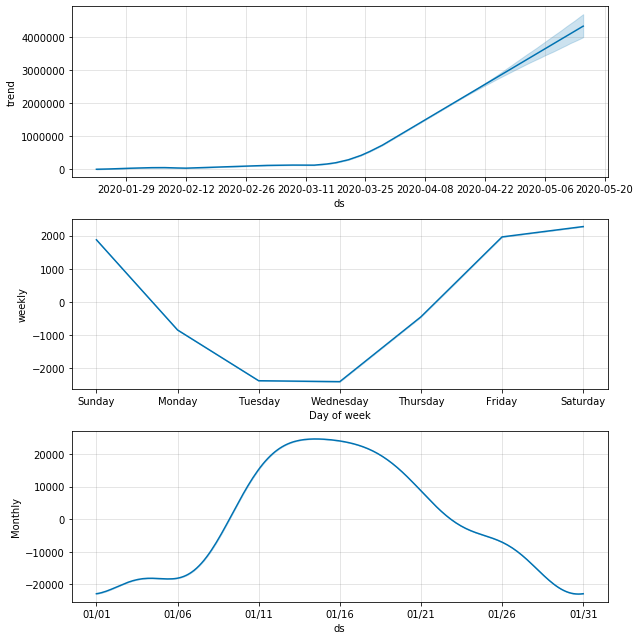

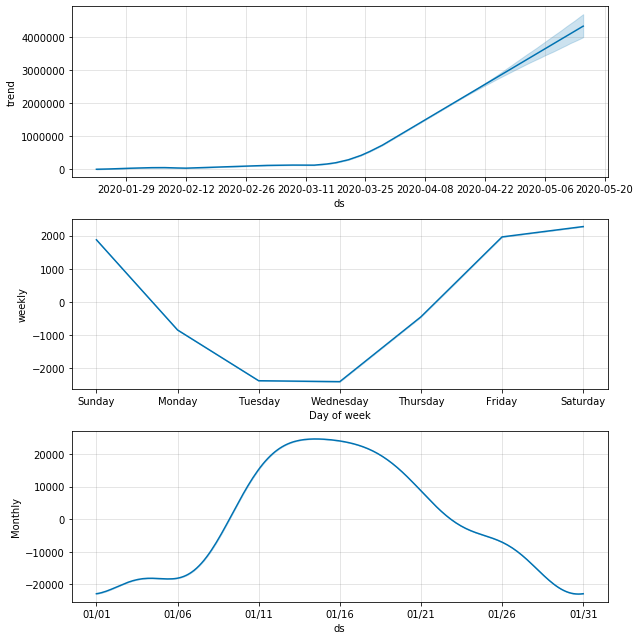

In [26]:
model.plot_components(predictions)

In [27]:
from fbprophet.plot import add_changepoints_to_plot

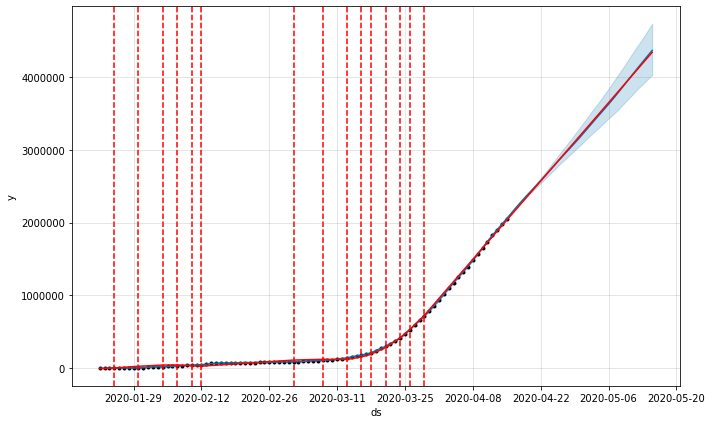

In [28]:
fig = model.plot(predictions)
changes = add_changepoints_to_plot(fig.gca(), model, predictions)

In [29]:
def determinate_beta_gamma_delta(data=None):
    '''
        this function compute transmission rate, recovered rate and fatalities rate over time
        params: data
        return: beta, gamma, delta
    '''
    
    beta = []
    gamma = []
    delta = []
    
    for t in range(len(data.Date.values)):
        
        x = data.Confirmed.iloc[t]
        y = data.Deaths.iloc[t]
        z = data.Recovered.iloc[t]
        w = data.currentCase.iloc[t]
        
        if x == 0.0:
            beta.append(0)
            gamma.append(0)
            delta.append(0)
        else:
            beta_t = w/x
            gamma_t = z/x
            delta_t = y/x
            
            beta.append(beta_t)
            gamma.append(gamma_t)
            delta.append(delta_t)
            
    return np.array(beta), np.array(gamma), np.array(delta)        

In [30]:
transmission, recovery, fatality = determinate_beta_gamma_delta(data=global_cases)

In [31]:
parameter_dynamic = pd.DataFrame()
parameter_dynamic['beta'] = transmission
parameter_dynamic['gamma'] = recovery
parameter_dynamic['delta'] = fatality
parameter_dynamic.index = global_cases.Date

In [32]:
parameter_dynamic.head()

,beta,gamma,delta
Date,,,
2020-01-22,0.918919,0.050450,0.030631
2020-01-23,0.926606,0.045872,0.027523
2020-01-24,0.934113,0.038257,0.027630
2020-01-25,0.943515,0.027197,0.029289
2020-01-26,0.949008,0.024551,0.026440


In [33]:
def find_R0(data=None):
    '''
        This function compute R0 over time
        params: data
        return: R0
    '''
    return data.beta.values/(data.gamma.values + data.delta.values)

In [34]:
#Compute R0
parameter_dynamic['R0'] = find_R0(data=parameter_dynamic)
print(parameter_dynamic['R0'].min())
parameter_dynamic.columns=['\u03B2', '\u03B3', '\u03B4','R0']
parameter_dynamic.columns

0.7027986665632994


Index(['β', 'γ', 'δ', 'R0'], dtype='object')

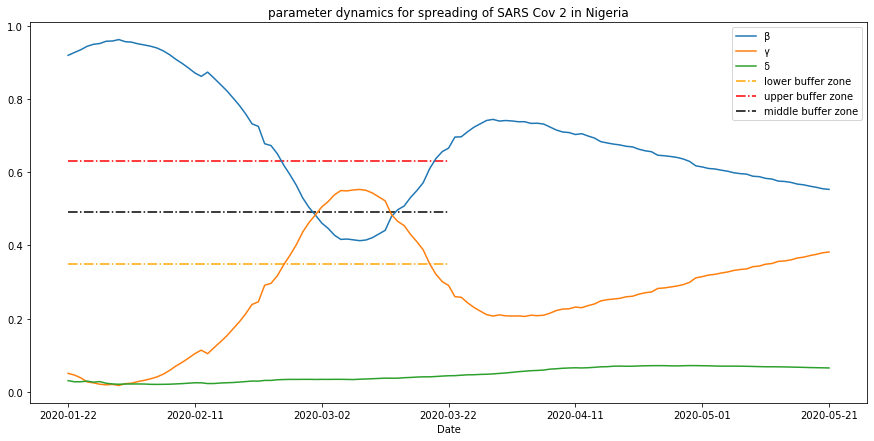

In [35]:
parameter_dynamic[['\u03B2', '\u03B3', '\u03B4']].plot(figsize=(15,7))
plt.hlines(0.35, 0, 60, linestyles='dashdot',color='orange',label='lower buffer zone')
plt.hlines(0.63, 0, 60, linestyles='dashdot',color='red', label='upper buffer zone')
plt.hlines(0.49, 0, 60, linestyles='dashdot', color='black',label='middle buffer zone')
plt.legend(loc='best')
plt.title('parameter dynamics for spreading of SARS Cov 2 in Nigeria')
plt.savefig('paramater dynamics.png')

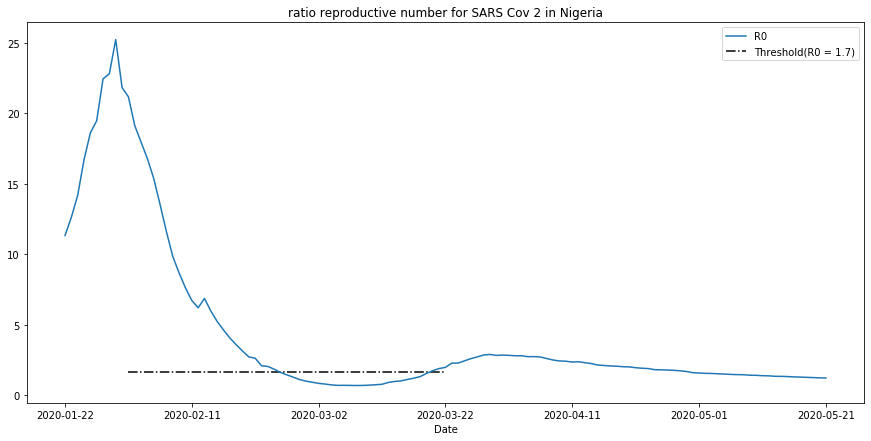

In [36]:
# Plot R0
parameter_dynamic['R0'].plot(figsize=(15,7))
plt.hlines(1.67, 10, 60, linestyles='dashdot', label='Threshold(R0 = 1.7)')
plt.legend(loc='best')
plt.title('ratio reproductive number for SARS Cov 2 in Nigeria')
plt.savefig('reproductive rate.png')

In [37]:
def growth_rate(data=None):
    """
        This function compute a growth rate of one variable
        params: data
        return: growth rate x
    
    """
    x = []
    x.append(0)
    for i in range(data.shape[0]-1):
        a = data.iloc[i+1]-data.iloc[i]
        b = a/data.iloc[i]
        x.append(b)
        
    return np.array(x)

In [38]:
growth_rate_currentCase = pd.DataFrame(growth_rate(data=global_cases.currentCase), columns=['currentCase'],
                                       index=global_cases.Date)

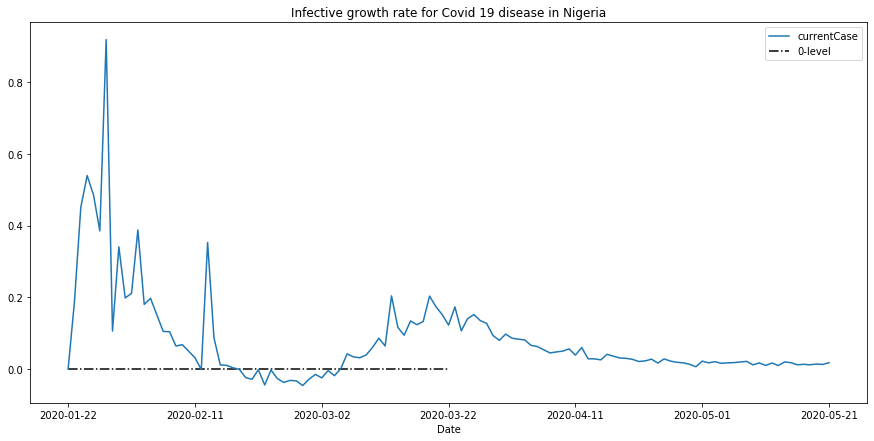

In [39]:
growth_rate_currentCase.plot(figsize=(15,7))
plt.hlines(0, 0, 60, linestyles='dashdot', label='0-level')
plt.legend(loc='best')
plt.title('Infective growth rate for Covid 19 disease in Nigeria')
plt.savefig('Growthrate.png')